#### From the IBL database, get data on weight and trial counts under different water regimes at CSHL
Anne Urai, CSHL, 2019

In [1]:
# PYTHON STARTS BY IMPORTING 'MODULES' AND 'PACKAGES' THAT WE'LL USE LATER

# GENERAL THINGS FOR COMPUTING AND PLOTTING
import pandas as pd
import numpy as np
import os, sys, time

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", context="talk")

# set a path where you want figures to be saved
figpath  = os.path.join(os.path.expanduser('~'), 'Data/Figures_IBL')

# ibl specific things
import datajoint as dj
from ibl_pipeline import reference, subject, action, acquisition, data, behavior
from ibl_pipeline.analyses import behavior as behavioral_analyses

# set path for saving figures
figpath  = os.path.join(os.path.expanduser('~'), 'Data/Figures_IBL')


Connecting anneurai@datajoint.internationalbrainlab.org:3306


If your login to DataJoint was successful, you should see something like 

'Connecting youruser@datajoint.internationalbrainlab.org:3306'

In [2]:
# FIND THE DATA WE NEED
# FIRST, WHICH SUBJECTS ARE DOING THIS CA EXPERIMENT?
subj = (subject.Subject() - subject.Death & 'subject_birth_date < "2018-09-01"').proj('subject_nickname', 'sex') * \
    (subject.SubjectLab() & 'lab_name="churchlandlab"').proj()
print(subj)

*subject_uuid  subject_nickna sex    
+------------+ +------------+ +-----+
1208c089-8b8e- IBL_13         M      
3e97e1d3-2a0f- IBL_34         M      
3f854f88-7879- IBL_11         M      
52a800fc-cbbc- IBL_1          M      
55381f61-4e47- IBL_46         M      
7c751b49-55a6- IBL_10         M      
 (Total: 6)



In [3]:
# get date for each weighing
weight_with_date = action.Weighing.proj('weight', session_date='DATE(weighing_time)')
# create a table with primary key to be the combination of subject_uuid and session_date
# dj.U, U means uniform, all possible combinations of subject uuid and session_date, when
# restricted with weight_with_date, it returns all existing combinations of subject_uuid and 
# session_date in the table weight_with_date
# Note that there are more entries in weight_with_date than in weight_date, indicating there
# exists more than one weighing for some dates.
weight_date = (dj.U('subject_uuid', 'session_date') & weight_with_date)

# Aggregation to get average weight for each date
# before .aggr is the table you want aggregate, basically you get one value for each entry in 
# weight_with_date
# first argument is the table that is useful to compute the value you need, here weight_with_date
# provides all weights for each date, 'weight' is an attribute in the table weight_with_date
# note that the results have the same number of entries as weight_date
avg_weight_date = weight_date.aggr(weight_with_date, avg_weight='AVG(weight)')

# NOW DO THE SAME FOR WATER
water_with_date = action.WaterAdministration.proj('watertype_name', 'water_administered', 'adlib',
                                                  session_date='DATE(administration_time)')
water_date = (dj.U('subject_uuid', 'session_date') & water_with_date)
# total_water_date = water_date.aggr(water_with_date, total_water='SUM(water_administered)', 
#                                    watertype="CONCAT_WS('; ', watertype_name)")
total_water_date = water_date.aggr(water_with_date, total_water='SUM(water_administered)', 
                                   watertype="GROUP_CONCAT(DISTINCT watertype_name SEPARATOR '; ')", 
                                   adlib='MAX(adlib)')
# total_water_date = dj.U('subject_uuid', 'session_date').aggr(
#     water_with_date, 
#     total_water='SUM(water_administered)', 
#     watertype="GROUP_CONCAT(DISTINCT watertype_name SEPARATOR '; ')", 
#     adlib='MAX(adlib)') & 'session_date > "2019-03-17"'

# get session with date
session_with_date = behavior.TrialSet.proj('n_trials') \
    * (acquisition.Session.proj(session_date='DATE(session_start_time)') & 'session_date > "2019-03-17"') \
    * behavioral_analyses.PsychResults()

# Now you can join (*) the two tables avg_weight_date and session_with_date.
# Join * will automatically find matched session_date in both tables, and only show entries where
# these dates exist in both tables. Note there are fewer entries in this resulting table, because
# on some dates weight is missing and other dates session is missing
b = subj * session_with_date * avg_weight_date * total_water_date

df = pd.DataFrame(b.fetch(as_dict=True))
df.tail(n=10)



# # TODO: updated code from Shan and Dimitri
# weight_with_date = action.Weighing.proj('weight', session_date='DATE(weighing_time)')
# water_with_date = action.WaterAdministration.proj('watertype_name', 'water_administered', 'adlib', 
#     session_date='DATE(administration_time)')
# total_water_date = dj.U('subject_uuid', 'session_date').aggr(
#     water_with_date, 
#     total_water='SUM(water_administered)', 
#     watertype="GROUP_CONCAT(DISTINCT watertype_name SEPARATOR '; ')", 
#     adlib='MAX(adlib)') & 'session_date > "2019-05-01"'

# # get session with date
# session_with_date = behavior.TrialSet.proj(
#     'n_trials', session_date='DATE(session_start_time)') & 'session_date > "2019-05-01"'

# # Here you can get the all info including total water, adlib, average weight, and number of sessions per day
# water_session =  total_water_date.aggr(session_with_date, n_sessions="count(n_trials)", keep_all_rows=True) * total_water_date
# water_weight_session = water_session.aggr(weight_with_date, avg_weight='AVG(weight)', keep_all_rows=True) * water_session

,adlib,avg_weight,bias,lapse_high,lapse_low,n_trials,n_trials_stim,n_trials_stim_right,performance,performance_easy,prob_choose_right,session_date,session_start_time,sex,signed_contrasts,subject_nickname,subject_uuid,threshold,total_water,watertype
500,1,26.670000,50.819900,1.286450e-01,8.267360e-02,175,"[20, 18, 11, 13, 17, 24, 29, 20, 23]","[2, 1, 2, 2, 3, 10, 8, 4, 17]",0.542857,0.813953,"[0.1, 0.05555555555555555, 0.18181818181818182...",2019-07-12,2019-07-12 13:43:08,M,"[-1.0, -0.25, -0.125, -0.0625, 0.0, 0.0625, 0....",IBL_10,7c751b49-55a6-4eac-9bdb-367faf2a18ee,73.5931,0.285,Water; Water 10% Sucrose; Water 2% Citric Acid
501,0,23.620001,-0.415344,3.657880e-02,2.319380e-02,1111,"[119, 117, 129, 139, 128, 116, 123, 118, 122]","[2, 4, 17, 40, 57, 89, 110, 111, 119]",0.848785,0.979253,"[0.01680672268907563, 0.03418803418803419, 0.1...",2019-07-15,2019-07-15 15:22:10,M,"[-1.0, -0.25, -0.125, -0.0625, 0.0, 0.0625, 0....",IBL_10,7c751b49-55a6-4eac-9bdb-367faf2a18ee,13.5454,2.829,Water 10% Sucrose
502,0,24.309999,0.882814,1.674220e-02,9.664710e-11,635,"[65, 68, 86, 79, 62, 80, 81, 63, 51]","[0, 2, 6, 23, 31, 56, 68, 58, 51]",0.851969,1.000000,"[0.0, 0.029411764705882353, 0.0697674418604651...",2019-07-16,2019-07-16 15:31:50,M,"[-1.0, -0.25, -0.125, -0.0625, 0.0, 0.0625, 0....",IBL_10,7c751b49-55a6-4eac-9bdb-367faf2a18ee,16.8171,1.623,Water 10% Sucrose
503,0,24.059999,8.200450,3.735240e-01,1.896550e-02,580,"[67, 60, 67, 74, 66, 72, 62, 50, 62]","[2, 1, 1, 6, 14, 21, 22, 30, 39]",0.691379,0.806202,"[0.029850746268656716, 0.016666666666666666, 0...",2019-07-17,2019-07-17 17:34:36,M,"[-1.0, -0.25, -0.125, -0.0625, 0.0, 0.0625, 0....",IBL_10,7c751b49-55a6-4eac-9bdb-367faf2a18ee,16.2497,1.203,Water 10% Sucrose
504,0,23.639999,2.141070,4.069390e-02,6.773620e-03,1101,"[148, 138, 126, 128, 103, 103, 124, 111, 120]","[1, 1, 9, 22, 38, 66, 107, 103, 117]",0.870118,0.985075,"[0.006756756756756757, 0.007246376811594203, 0...",2019-07-18,2019-07-18 14:13:04,M,"[-1.0, -0.25, -0.125, -0.0625, 0.0, 0.0625, 0....",IBL_10,7c751b49-55a6-4eac-9bdb-367faf2a18ee,12.9533,2.874,Water 10% Sucrose
505,1,24.410000,1.579430,1.684470e-02,3.639270e-02,672,"[70, 74, 68, 86, 71, 67, 74, 81, 81]","[3, 4, 14, 22, 35, 48, 56, 74, 80]",0.834821,0.966887,"[0.04285714285714286, 0.05405405405405406, 0.2...",2019-07-19,2019-07-19 15:12:38,M,"[-1.0, -0.25, -0.125, -0.0625, 0.0, 0.0625, 0....",IBL_10,7c751b49-55a6-4eac-9bdb-367faf2a18ee,20.0828,1.683,Water 10% Sucrose; Water 2% Citric Acid
506,1,26.160000,2.197240,8.710590e-02,3.654630e-02,664,"[71, 60, 65, 63, 70, 76, 97, 80, 82]","[3, 2, 5, 15, 27, 45, 78, 72, 75]",0.817771,0.934641,"[0.04225352112676056, 0.03333333333333333, 0.0...",2019-07-23,2019-07-23 15:40:41,M,"[-1.0, -0.25, -0.125, -0.0625, 0.0, 0.0625, 0....",IBL_10,7c751b49-55a6-4eac-9bdb-367faf2a18ee,13.5943,1.629,Water 10% Sucrose; Water 2% Citric Acid
507,1,25.690001,4.483220,2.890650e-09,3.097180e-03,453,"[54, 42, 58, 44, 44, 64, 47, 48, 52]","[0, 1, 8, 12, 15, 31, 34, 46, 52]",0.821192,1.000000,"[0.0, 0.023809523809523808, 0.1379310344827586...",2019-07-24,2019-07-24 13:40:14,M,"[-1.0, -0.25, -0.125, -0.0625, 0.0, 0.0625, 0....",IBL_10,7c751b49-55a6-4eac-9bdb-367faf2a18ee,20.2059,1.116,Water 10% Sucrose; Water 2% Citric Acid
508,1,25.389999,-3.032510,1.064360e-02,5.898280e-02,649,"[77, 71, 78, 69, 69, 73, 74, 77, 61]","[4, 7, 17, 24, 50, 60, 66, 75, 61]",0.833590,0.971014,"[0.05194805194805195, 0.09859154929577464, 0.2...",2019-07-25,2019-07-25 14:05:49,M,"[-1.0, -0.25, -0.125, -0.0625, 0.0, 0.0625, 0....",IBL_10,7c751b49-55a6-4eac-9bdb-367faf2a18ee,15.4273,1.623,Water 10% Sucrose; Water 2% Citric Acid
509,1,25.379999,-3.670340,5.473150e-02,1.000390e-01,507,"[48, 45, 42, 57, 59, 56, 72, 72, 56]","[5, 6, 10, 29, 38, 41, 62, 69, 52]",0.792899,0.913462,"[0.10416666666666667, 0.13333333333333333, 0.2...",2019-07-26,2019-07-26 14:12:17,M,"[-1.0, -0.25, -0.125, -0.0625, 0.0, 0.0625, 0....",IBL_10,7c751b49-55a6-4eac-9bdb-367faf2a18ee,17.1970,1.206,Water; Water 

In [4]:
# ADD SOME MORE USEFUL INFO - group by week, from Saturday to Friday
df['session_date'] = pd.to_datetime(df.session_date)
df['week_number']  = df['session_date'].dt.week
df['weekday_name'] = df['session_date'].dt.day_name()
df['weekday']      = df['session_date'].dt.weekday

# THEN GIVE EVERY WEEK A CONDITION NAME!
#
# let's define 5 conditions
# O = one mL water in weekend, sucrose water in task
# C = citric acid water in weekend, sucrose water in task
# CC = citric acid water in weekend + week, sucrose water in task
# W = regular water in weekend, sucrose water in task
# WW = regular water in weekend + week, sucrose water in task
#
# now, we want to map these onto the week numbers
condition_map = {10:'CC', 11:'C', 12:'C', 13:'C', 14:'C', 15:'C', 16:'C', 
                 17:'CC', 18:'C', 19:'WW', 20:'O', 21:'C', 22:'C', 23:'C', 24:'C', 25:'WW',
                26:'O*', 27:'CC', 28:'WW', 29:'O', 30:'CC', 31:'W', 32:'O', 33:'W'}

df['condition'] = df.week_number.map(condition_map)

# SHOW THIS, AND CHECK THAT IT'S CORRECT!
sanitycheck = df.groupby(['week_number', 'condition', 'session_date', 'weekday_name'])['watertype'].unique()
sanitycheck.to_csv(os.path.join(figpath, "check_water_conditions.csv"))
sanitycheck

/anaconda3/envs/djenv/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


week_number  condition  session_date  weekday_name
12           C          2019-03-18    Monday                                        [Water 10% Sucrose]
                        2019-03-19    Tuesday                                       [Water 10% Sucrose]
                        2019-03-20    Wednesday                                     [Water 10% Sucrose]
                        2019-03-21    Thursday                                      [Water 10% Sucrose]
                        2019-03-22    Friday          [Water 10% Sucrose; Water 2% Citric Acid, Wate...
13           C          2019-03-25    Monday                                        [Water 10% Sucrose]
                        2019-03-26    Tuesday                                       [Water 10% Sucrose]
                        2019-03-27    Wednesday                                     [Water 10% Sucrose]
                        2019-03-28    Thursday         [Water 10% Sucrose, Hydrogel; Water 10% Sucrose]
             

In [5]:
# MAKE NICE-LOOKING DATE AXES
import matplotlib.dates as mdates
def fix_date_axis(ax):
    ax.xaxis_date()
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.SUNDAY))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
    for item in ax.get_xticklabels():
        item.set_rotation(60)

/anaconda3/envs/djenv/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


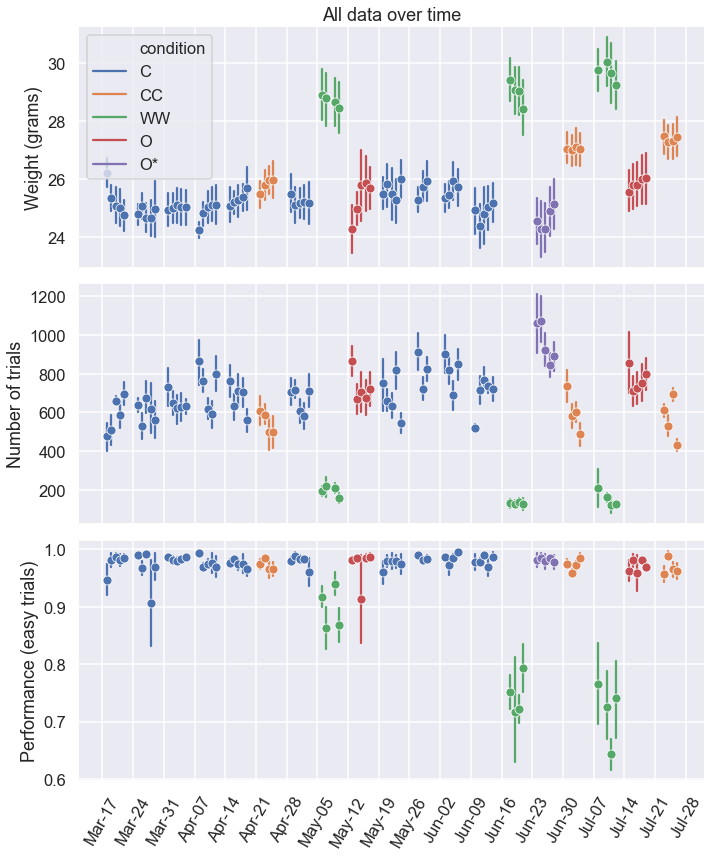

In [6]:
## NOW PLOT WITH SEABORN
f, ax = plt.subplots(3,1, sharex=True, figsize=(10, 12))
sns.lineplot(x="session_date", y="avg_weight", err_style='bars', ci=68, hue="condition", marker='o', 
             linewidth=0, data=df, ax=ax[0])
ax[0].set(ylabel="Weight (grams)", xlabel="Days")
sns.lineplot(x="session_date", y="n_trials", err_style='bars', ci=68, hue="condition", marker='o',  
             linewidth=0, data=df, ax=ax[1], legend=False)
ax[1].set(ylabel="Number of trials", xlabel="")
sns.lineplot(x="session_date", y="performance_easy", err_style='bars', ci=68, hue="condition", marker='o',  
             linewidth=0, data=df, ax=ax[2], legend=False)
ax[2].set(ylabel="Performance (easy trials)", xlabel="")

# set grid to show Mondays
fix_date_axis(ax[2])
ax[0].set_title('All data over time')
f.tight_layout()
f.savefig(os.path.join(figpath, "CA_over_time.pdf"))

Now that we have our data, let's visualize it!

The plot above shows an example of using seaborn (https://seaborn.pydata.org/index.html), see the documentation for many other types of plots you can make. 

Try to make this plot a bit nicer, by doing the following:
1. move the legend to the right of the plot, or make it smaller so it doesn't obscure the datapoints. you can also rotate the 'tickmarks' (dates) on the x-axis to make them more readable.
- make an additional column with the day of the week

2. play with the arguments to 'lineplot' - see e.g. what happens when linewidth=1, or ci=95
3. instead of marking each day by its water condition _that day_, change the dataframe to label it with the condition of _that week_ (so that e.g. a week with only 10% sucrose water, but _preceded_ by a 2% CA weekend is different from a week with 10% sucrose water, but _preceded by a regular water weekend). this should then indicate the color
4. check in Alyx that all mice on a given day have the same 'condition'. Also make sure there are data logged for each day, including the weekend.
4. repeat the plot for individual mice (hint: seaborn's FacetGrid)


Of these, 3 and 4 are the most important: the rest is 

Once this looks good, try to create a new plot that ignores the date, and plots all datapoints (weight and nr of trials) from one condition (weekend + week water regime) in one overview - as on the SfN poster. You can use e.g. seaborn's catplot to make it look nice.

Other todo (for Anne):
1. indicate Mondays 


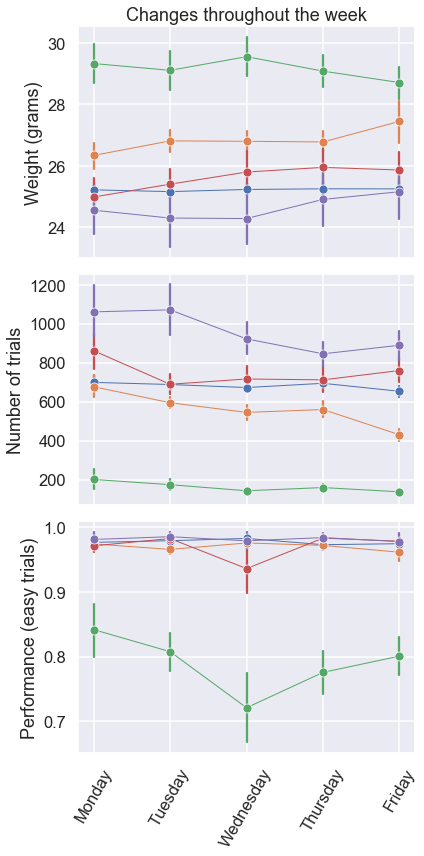

In [7]:
## NOW PLOT WITH SEABORN
f, ax = plt.subplots(3,1, sharex=True, figsize=(6, 12))
sns.lineplot(x="weekday", y="avg_weight", err_style='bars', ci=68, hue="condition", marker='o', 
             linewidth=1, data=df, ax=ax[0], legend=False)
ax[0].set(ylabel="Weight (grams)")
sns.lineplot(x="weekday", y="n_trials", err_style='bars', ci=68, hue="condition", marker='o',  
             linewidth=1, data=df, ax=ax[1], legend=False)
ax[1].set(ylabel="Number of trials")
sns.lineplot(x="weekday", y="performance_easy", err_style='bars', ci=68, hue="condition", marker='o',  
             linewidth=1, data=df, ax=ax[2], legend=False)
ax[2].set(ylabel="Performance (easy trials)", xticks=[0,1,2,3,4], 
          xticklabels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], xlabel="")

for item in ax[2].get_xticklabels():
    item.set_rotation(60)
    
# set grid to show Mondays
ax[0].set_title('Changes throughout the week')
f.tight_layout()
f.savefig(os.path.join(figpath, "CA_within_week.pdf"))

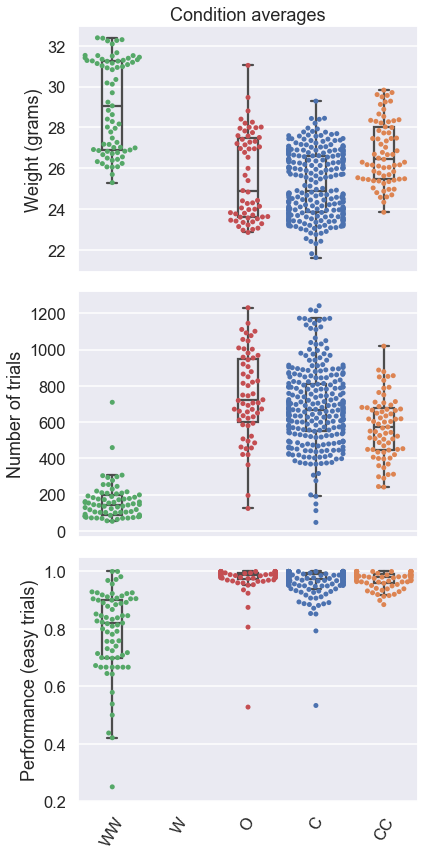

In [11]:
## NOW PLOT WITH SEABORN
f, ax = plt.subplots(3,1, sharex=True, figsize=(6, 12))

sns.swarmplot(x="condition", y="avg_weight", order=["WW", "W", "O", "C", "CC"], hue="condition", data=df, ax=ax[0])
sns.boxplot(x="condition", y="avg_weight", order=["WW", "W", "O", "C", "CC"], data=df, fliersize=0, ax=ax[0], boxprops={'facecolor':'None'}, width=.3)
ax[0].set(ylabel="Weight (grams)", xlabel="")
ax[0].get_legend().remove()

sns.swarmplot(x="condition", y="n_trials", order=["WW", "W", "O", "C", "CC"], hue="condition", data=df, ax=ax[1])
sns.boxplot(x="condition", y="n_trials", order=["WW", "W", "O", "C", "CC"], data=df, fliersize=0, ax=ax[1], boxprops={'facecolor':'None'}, width=.3)
ax[1].set(ylabel="Number of trials", xlabel="")
ax[1].get_legend().remove()

sns.swarmplot(x="condition", y="performance_easy", order=["WW", "W", "O", "C", "CC"], hue="condition", data=df, ax=ax[2])
sns.boxplot(x="condition", y="performance_easy", order=["WW", "W", "O", "C", "CC"], data=df, fliersize=0, ax=ax[2], boxprops={'facecolor':'None'}, width=.3)
ax[2].set(ylabel="Performance (easy trials)", xlabel="")
ax[2].get_legend().remove()

for item in ax[2].get_xticklabels():
    item.set_rotation(60)
    
# set grid to show Mondays
ax[0].set_title('Condition averages')
f.tight_layout()
f.savefig(os.path.join(figpath, "CA_stats.pdf"))

In [12]:
# NOW DO STATS ON THE TRIAL COUNTS
import statsmodels.api as sm
import statsmodels.formula.api as smf
md = smf.mixedlm("n_trials ~ condition", df, groups=df["subject_nickname"])
mdf = md.fit()
print(mdf.summary())

              Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    n_trials  
No. Observations:    510        Method:                REML      
No. Groups:          6          Scale:                 36446.1386
Min. group size:     82         Likelihood:            -3385.5657
Max. group size:     87         Converged:             Yes       
Mean group size:     85.0                                        
-----------------------------------------------------------------
                 Coef.   Std.Err.    z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept        682.644   29.352  23.257 0.000  625.115  740.172
condition[T.CC] -112.761   25.508  -4.421 0.000 -162.757  -62.765
condition[T.O]    62.109   27.342   2.272 0.023    8.520  115.697
condition[T.O*]  273.920   37.240   7.356 0.000  200.931  346.909
condition[T.WW] -523.131   25.360 -20.628 0.000 -572.835 -473.427
Group Var       4390.852

In [13]:
md = smf.mixedlm("avg_weight ~ condition", df, groups=df["subject_nickname"])
mdf = md.fit()
print(mdf.summary())

          Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: avg_weight
No. Observations:   510     Method:             REML      
No. Groups:         6       Scale:              0.7390    
Min. group size:    82      Likelihood:         -665.5289 
Max. group size:    87      Converged:          Yes       
Mean group size:    85.0                                  
----------------------------------------------------------
                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------
Intercept       25.221    0.696 36.222 0.000 23.856 26.586
condition[T.CC]  1.604    0.115 13.964 0.000  1.379  1.829
condition[T.O]   0.414    0.123  3.359 0.001  0.172  0.655
condition[T.O*] -0.520    0.168 -3.101 0.002 -0.849 -0.191
condition[T.WW]  3.917    0.114 34.304 0.000  3.694  4.141
Group Var        2.893    2.145                           

